In [1]:
# mainSim code
# AUG 9 2021


In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import brian2
import json
import pickle
import copy
import plotly.express as px

In [3]:
# load helper functions
from helper import generate_pref, plot_pref
import modelHelper
from helper import load_hierarchy, plot_connectivity, generate_connectivity, generate_random_connectivity

# load model class
from circuitModel import model

In [4]:
# load arealist
area_list = list(np.loadtxt('results/area_list.csv', delimiter=',', dtype='str'))
thal_list = list(np.loadtxt('results/thal_list.csv', delimiter=',', dtype='str'))
# load connectivity 
conn_cxcx = np.loadtxt('results/conn_cxcx.csv', delimiter=',')
conn_cxth = np.loadtxt('results/conn_cxth.csv', delimiter=',')
conn_thcx = np.loadtxt('results/conn_thcx.csv', delimiter=',')

conn_cxcx_raw = np.loadtxt('results/conn_cxcx_raw.csv', delimiter=',')
# load cell density
density_df = pd.read_csv("results/dfDensity.csv", header = 0, index_col=0)
# load volume
volume_df = pd.read_csv('results/dfVolume.csv', header = 0, index_col=0)

# load interneuron density
normPVgrad_df = pd.read_csv('results/dfPV.csv', header = 0, index_col=0)
normSSTgrad_df = pd.read_csv('results/dfSST.csv', header = 0, index_col=0)
PVgrad_df = pd.read_csv('results/dfPVraw.csv', header = 0, index_col= 0)
SSTgrad_df = pd.read_csv('results/dfSSTraw.csv', header = 0, index_col= 0)

# load hierarchy
hierarchy_df = pd.read_csv('results/dfHier.csv', header=0, index_col=0)
hierarchy = np.array(hierarchy_df['hierarchy index'])

In [5]:
# define divisions from Harris et al.
div = {'somatomotor':['SSp-bfd','SSp-tr','SSp-ll','SSp-ul',
                     'SSp-un','SSp-n','SSp-m','SSs','MOp','MOs'],
      'visual':['VISal','VISl','VISp','VISpl',
                'VISli','VISpor','VISrl'],
      'medial':['VISa','VISam','VISpm','RSPagl',
               'RSPd','RSPv'],
      'prefrontal':['FRP','ACAd','ACAv','PL',
                   'ILA','ORBl','ORBm','ORBvl'],
      'lateral':['AId','AIv','AIp','VISC',
                 'GU','TEa','PERI','ECT'],
      'auditory':['AUDd','AUDp','AUDpo','AUDv']}

div_color_list = np.array([[255, 140, 0],
                           [169, 164, 217],
                           [22, 37, 128],
                           [220,20,60],
                           [218,165,32],
                           [91,  0,  105]])/255
div_name_list = ['somatomotor',
                 'visual',
                 'medial',
                 'prefrontal',
                 'lateral',
                 'auditory']

In [6]:
# define parameters
parameters = {}
p = parameters
parameters['alpha_pref'] = 0
parameters['beta_pref'] = 2.42  # 2.42    2.55

parameters.update({'SF1': 1, # Jorge M scaling factor to keep rates in check, depreacated parameter
                    'SF2': 1})    # Jorge M scaling factor to keep rates in check, depreacated parameter
                   
parameters.update(
    { # Time constants
    'tau_NMDA': 0.06   * brian2.second,    # s 
    'tau_GABA': 0.005  * brian2.second,    # s 
    'tau_AMPA': 0.002  * brian2.second,    # not used in the model
    'tau_rates': 0.002 * brian2.second,    # same as tau_AMPA  changed from typo 0.02
    'tau_noise': 0.002 * brian2.second,    # same as tau_AMPA
    # f-I curve parameters - E populations
    'a_E': 140  * brian2.Hz/brian2.nA,  # Hz/nA
    'b_E': 54  * brian2.Hz,            # Hz
    'd_E': 0.308  * brian2.second,        # s
    'gamma_NMDA': 1.282,                         # unitless

    'gamma_AMPA':  2,            # TODO not determined
    # f-I curve parameters - I populations
    'g_2': 4,                    # unitless
    'c_I': 615  * brian2.Hz/brian2.nA,                 # Hz/nA
    'c_0': 177  * brian2.Hz,                           # Hz
    'gamma_GABA': 2,                       # unitless
    # Local connectivity matrix strengths
    # Strength of connections from E cells
    'g_E_self': 0.42 * brian2.nA , # nA   0.42 works for all cases. 
    'g_E_cross': 0.0107* brian2.nA,         # nA
    # Local connectivity E to I
    'g_I_E': 0.4087 * brian2.nA,
    # Strength of connections from I cells
    'g_E_I':  0.32    * brian2.nA,         # nA  key param to tune
    #0.32
    # larger g_E_I allows the Activity propagation to be stable, Balance amplification.
    # original -0.31
    'g_Iself': 0.15   * brian2.nA,         # 0.12 nA
    # John Murray's term
    'J_plus': 0.2112   * brian2.nA,         # nA - Matches value in John Murray's thesis for g_E_self - g_E_cross
    # Background inputs
    'I0_E': 0.305 * brian2.nA,         # nA
    #0.305 works well.
    #0.3294 gives PA for disconnected network also for multiple attractor.(multatt)
    #0.3294 gives PA for disconnected network and in this case a smaller kFLN (0.19)can make good propagation. 
    'I0_I': 0.26       * brian2.nA,         # nA
    #0.26
    # Noise std dev
    'std_noise': 0.005 * brian2.nA,         # nA      
#                     'std_noise': 0.000 * brian2.nA,         # nA      
    # initial values
    'r0_E': 5 * brian2.Hz,
    'r0_I': 5.5 * brian2.Hz
        })      
        
# deprecated parameters.
# parameters.update({ # Zetas
#     'zeta': parameters['c_I']*parameters['g_E_I']*parameters['tau_GABA']*parameters['gamma_GABA']\
#             /(parameters['g_2'] - parameters['g_Iself']*parameters['tau_GABA']*parameters['gamma_GABA']*parameters['c_I']),
#     'zeta2': 2*parameters['c_I']*parameters['tau_GABA']*parameters['gamma_GABA']*parameters['g_E_I']\
#             /(parameters['c_I']*parameters['tau_GABA']*parameters['gamma_GABA']*parameters['g_Iself'] - parameters['g_2']),
#         })    

parameters.update({ # Long-range strength
    'mu_EE': 1.8*0.05, # unitless - G in Jorge M's code key param to tune
        # larger mu_EE allows a loop-based persistent activity
        # original 0.86 for beta=4.4
    'ratio_mu_IE_mu_EE': 3/1.8
        # original 0.48
        })    
parameters.update({'mu_IE': parameters['mu_EE']*parameters['ratio_mu_IE_mu_EE']})

######## HIERARCHY ########
# TODO: need to rewrite this part of code for clarity
parameters.update({
    'JEE_scaling_factor' : 0,  # eta in Chaudhuri et al., 2015
   'JEI_scaling_factor' : 0.5,  #|scaling| should be smaller than 1  # JEI scaling -0.8 working.
  'JII_scaling_factor' : 0.5, # JII scaling -0.6 working.
    'JIE_scaling_factor': 0.5,

  'J_NS_grad_min' : 1, #J_N_IE_min is not needed, since it is determined by Jorge's equation.
   'J_G_EI_min' : 0.6, # note that this is negative
    'J_G_II_min' : 0.7, #note that this is negative  #Scale the local E to E,local I to E,LR EE synapses to lie according to the hierarchy
    """"""
    'J_N_IE_min' : 1,
    """"""    """"""

#                     'kFln' : 0.05, # when using fln max to normalize, kfln=0.085 not 0.85
   # fln_squish = kFln*np.power(fln,kSquishFln) # 1 for usual model  0.09 for multiple attractor; 0.13 for mult attractor.(multatt)
   'kSquishFln' : 0.3, # to make the fln vary in a smaller range. fln_squish = kFln*np.power(fln,kSquishFln) 
                # Set up the matrix that defines how different populations between different areas interact with each other
    'LR_E_self' : 1,
    'LR_E_cross' : 0,  # Don't have any long-range cross population conns
    'LR_I_E' : 1,
    # Choose stimulus and distractor strength
    'stim_strength' : 0.07 * brian2.nA, # stim length changed to 1s.   0.1*nA and stim length 0.5s before
    'inh_strength' : -0.1*brian2.nA,
    'BLA_stim_strength' : 0.2*brian2.nA, 
    'thalamic_base_strength' : 0.05* brian2.nA,  # I choose to make it smaller than stim strength. 
    # original 0.3
    'distractor_strength' : 0 * brian2.nA, 
    'inhibition_strength' : -0.3* brian2.nA
    }) 

# Th CX model
parameters.update({
    'stim_strength_th':0.1*brian2.nA,    # nA
  'I0_th_E': 0.305 * brian2.nA,         # nA
   'g_th_cx_E': 0.01    * brian2.nA,         # nA TODO tunable
   'g_th_cx_I': 0 * brian2.nA,          #nA  no connection from th to cx interneuron.
   'g_cx_th': 0.01      * brian2.nA,
   'p_D': 0.45,        # parameters for STD
   'tau_D': 600*brian2.ms        # parameters for STD
  })

parameters['dt']=0.5 * brian2.ms  # timestep  
parameters['trial_length']=10000 * brian2.ms # trial length (s)
parameters['inh_multiarea'] = []
parameters['PAthreshold'] = 5 #Hz

parameters['stim_on'] = 3*brian2.second
parameters['stim_off'] = 4*brian2.second

parameters['inh_stim_on'] =  7*brian2.second
parameters['inh_stim_off'] =  8*brian2.second

parameters['div'] = div
parameters['div_color_list'] = div_color_list
parameters['div_name_list'] = div_name_list

0.9183397445384054


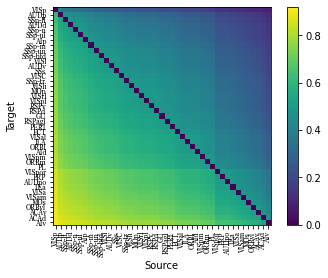

In [7]:
# # generate preference matrix using pv density
# a = np.array(normPVgrad_df)
# # a = np.expand_dims(PVNormByDen, 1)

# b = np.matlib.repmat(a,1,len(a))
# for i in range(b.shape[0]):
#     b[i,i] = 0
# parameters['minValueLR'] = 0 # 0.5
# parameters['slopeLR'] = 1
# pref_matrix = parameters['slopeLR'] * b + parameters['minValueLR']  # 0.5 * (b - 0.5) + 0.5 when W_E = W*(pref)
# # plt.imshow(pref_matrix)
# # plt.colorbar()

# np.fill_diagonal(pref_matrix, 0)

# generate longrange preferential targeting matrix via hierarchy
pref_matrix = generate_pref(hierarchy, parameters)
# pref_matrix = pref_matrix.T
plot_pref(pref_matrix, area_list)
print(np.max(pref_matrix))

# # control case: mij = 0.5
# pref_matrix = np.ones(pref_matrix.shape) * 0.5
# np.fill_diagonal(pref_matrix, 0)
# plot_pref(pref_matrix, area_list)

In [8]:
# set up parameters not changed
parameters['stim_on'] = 2 * brian2.second
parameters['stim_off'] = 2.5 * brian2.second

parameters['distract_on'] = 9.5 * brian2.second
parameters['distract_off'] = 12 * brian2.second

parameters['inh_strength'] = - 0.4 * brian2.nA
parameters['inh_stim_on'] = 10 * brian2.second
parameters['inh_stim_off'] = 13 * brian2.second
parameters['std_noise'] = 0.005 * brian2.nA # 0.005 for simulations  
#####
parameters['WNormalizedbyRow'] = False
###########################

######
parameters['I0_E_mean'] = 0.305 * brian2.nA   #284 thala  #305 cortex
######
parameters['I0_E_min'] = parameters['I0_E_mean']
parameters['I0_E_max'] = parameters['I0_E_mean']

#######################
parameters['I0_th_E'] = 0.405 * brian2.nA  # 0.405*brian2.nA            #0.385*brian2.nA         #0.355 * brian2.nA   #0.285 * brian2.nA
# parameters['g_th_cx_E'] = 0.8 * brian2.nA  #0.6 #0.15*brian2.nA          #0.18*brian2.nA       #0.1    * brian2.nA
parameters['g_th_cx_I'] = 0 * brian2.nA       # 0 * brian2.nA
parameters['g_cx_th'] = 0.12 * brian2.nA #0.15 #0.15*brian2.nA  #0.18*brian2.nA         #0.1      * brian2.nA

parameters['g_th_cx_E_mean'] = 2.2* brian2.nA  # 0.8  #1.1  #1.85
k_gth_E = 1.1 * brian2.nA  #0.8   #1.2 for the alternate regime where the MOs lose firing after inhibition.  # 0.7
parameters['g_th_cx_E_min'] = parameters['g_th_cx_E_mean'] - k_gth_E*0.5
parameters['g_th_cx_E_max'] = parameters['g_th_cx_E_mean'] + k_gth_E*0.5

parameters['g_th_cx_E_mode'] = 'linear' #'logistic'
parameters['g_th_cx_E_logistic_k'] = 20

######## PV local gradient
parameters['J_G_EI_min'] = 0.6   # 0.6
parameters['JEI_scaling_factor'] = 0.5  # 0.5  # 0.6 gives a good example of senerio 2. 
# parameters['J_G_EI_min'] = 0.55
# parameters['JEI_scaling_factor'] = 0.5

parameters['J_G_II_min'] = 0.7   # 0.7
parameters['JII_scaling_factor'] = 0.5  # 0.5
# parameters['J_G_II_min'] = 0.65
# parameters['JII_scaling_factor'] = 0.5

parameters['J_N_IE_min'] = 1   # 0.65  #0.5    0.8  for alternative regime
parameters['JIE_scaling_factor'] = 0   #0.5

# parameters['J_N_IE_min'] = 0.65   # 0.65   #0.5
# parameters['JIE_scaling_factor'] = 0.5  #0.5

####### connectivity scaling
parameters['kSquishFln'] = 0.3  # 0.3

parameters['g_th_cx_I_mean'] = 1.6 * brian2.nA # 0.8
k_gth_I = 1.1 * brian2.nA 
parameters['g_th_cx_I_min'] = parameters['g_th_cx_I_mean'] - k_gth_I*0.5
parameters['g_th_cx_I_max'] = parameters['g_th_cx_I_mean'] + k_gth_I*0.5
parameters['g_th_cx_I_mode'] = 'linear' 
parameters['g_th_cx_I_logistic_k'] = 20 

parameters['g_th_cx_E_midpoint'] = 0.7
parameters['g_th_cx_I_midpoint'] = parameters['g_th_cx_E_midpoint']

parameters['a_E'] = 140 * brian2.Hz/brian2.nA  # Hz/nA  #280
parameters['b_E'] = 54 * brian2.Hz            # Hz

######
parameters['d_E'] = 0.308 * brian2.second        # s   # 0.154   #0.4  # 0.6
######

parameters['figurefolder'] = 'figure/'

In [9]:
# mainsim mm11
parameters['trial_length'] = 6000 * brian2.ms # trial length (s) 
parameters['stim_strength'] = 0.5 * brian2.nA  # 7pA  0.8nA
parameters['distract_strength'] = 10 * parameters['stim_strength']
parameters['std_noise'] = 0.005 * brian2.nA  # 0.005 *  brian2.nA
#####
# 0.1 original working parameter
parameters['mu_EE'] = 0.1 * brian2.nA     #0.06*1.8 cortical #0.025*1.8  # 0.015*1.8  #0.058*1.8 thal  # 0.065*1.8 PV only   # 0.06*1.8 PV only is really good! 
# 0.065   0.1
# 0.087
# parameters['mu_EE'] = 0 * brian2.nA    # 0.09 multiple attractor   #0.03~0.05 multiple attractor with gee = 0.505
######
parameters['g_E_self'] = 0.4 * brian2.nA      #0.4 cortical  # 0.505 for isolated areas use only #0.2 thalamc
######
parameters['ratio_mu_IE_mu_EE'] = 3/1.8  #4.5/1.8 thalam #  3/1.8 cortical
parameters.update({'mu_IE': parameters['mu_EE'] * parameters['ratio_mu_IE_mu_EE']})

# inhibitory parameters
# fix the gEImin to be 1, only change the scaling factor and g_E_I. 
# reference parameter: 0.18 (1+0.89*PV)    alternative: 0.075 (1+10*PV)
parameters['J_G_EI_min'] = 1   # 0.6 # fixed to be 1 
parameters['JEI_scaling_factor'] = 0.83  # 0.5  # 0.6 gives a good example of senerio 2. 
parameters['g_E_I'] =  0.192  * brian2.nA         # nA  key param to tune  'g_E_I':  0.32    * brian2.nA,  

# inhibitory strength
parameters['g_I_E'] = 0.2656 * brian2.nA  #'g_I_E': 0.4087 * brian2.nA,  * 0.65 since the local gie = 0.65 was absorbed in


# Strength of connections from I cells
# TODO: change JGII

parameters['J_G_II_min'] = 1   # 0.7
parameters['JII_scaling_factor'] = 0.714  # 0.5
parameters['g_Iself'] = 0.105   * brian2.nA        # nA  'g_Iself': 0.15   * brian2.nA, 

savefigflag = False
thcxmodel = False
distractionInput = False
parameters['thcxmodel'] = thcxmodel
parameters['distractionInput'] = distractionInput

# set random seed
np.random.seed(42)
model_V1 = model(parameters, False, conn_cxcx, pref_matrix, hierarchy_df, normPVgrad_df, normSSTgrad_df, area_list, thcxmodel, conn_thcx, conn_cxth, thal_list)
if not thcxmodel:
    model_V1.add_input(parameters['stim_strength'],['VISp'], parameters['stim_on'], parameters['stim_off'], 'E1') 
    
    if distractionInput:
        model_V1.add_input(parameters['distract_strength'], ['VISp'], parameters['distract_on'], parameters['distract_off'], 'E2')

if thcxmodel:
    model_V1.add_input_TH_new(parameters['stim_strength'], ['VISp'], parameters['stim_on'], parameters['stim_off'], 'E1', rampingperiod=0)
    if distractionInput:
        model_V1.add_input_TH_new(parameters['distract_strength'], ['VISp'], parameters['distract_on'], parameters['distract_off'], 'E2', rampingperiod=0)

model_V1.run_sim(vocal_prompt = False)
[persistentactlist,baselineactlist,LRtoElist,LRtoIlist] = model_V1.save_delay_activity('tempdata/',False)
if model_V1.thcxmodel == True:
    th_persistentactlist = model_V1.save_th_delay_activity('tempdata/',False)


VISp
simulation start: 
sim done.


2.13E-17
3.95E-03


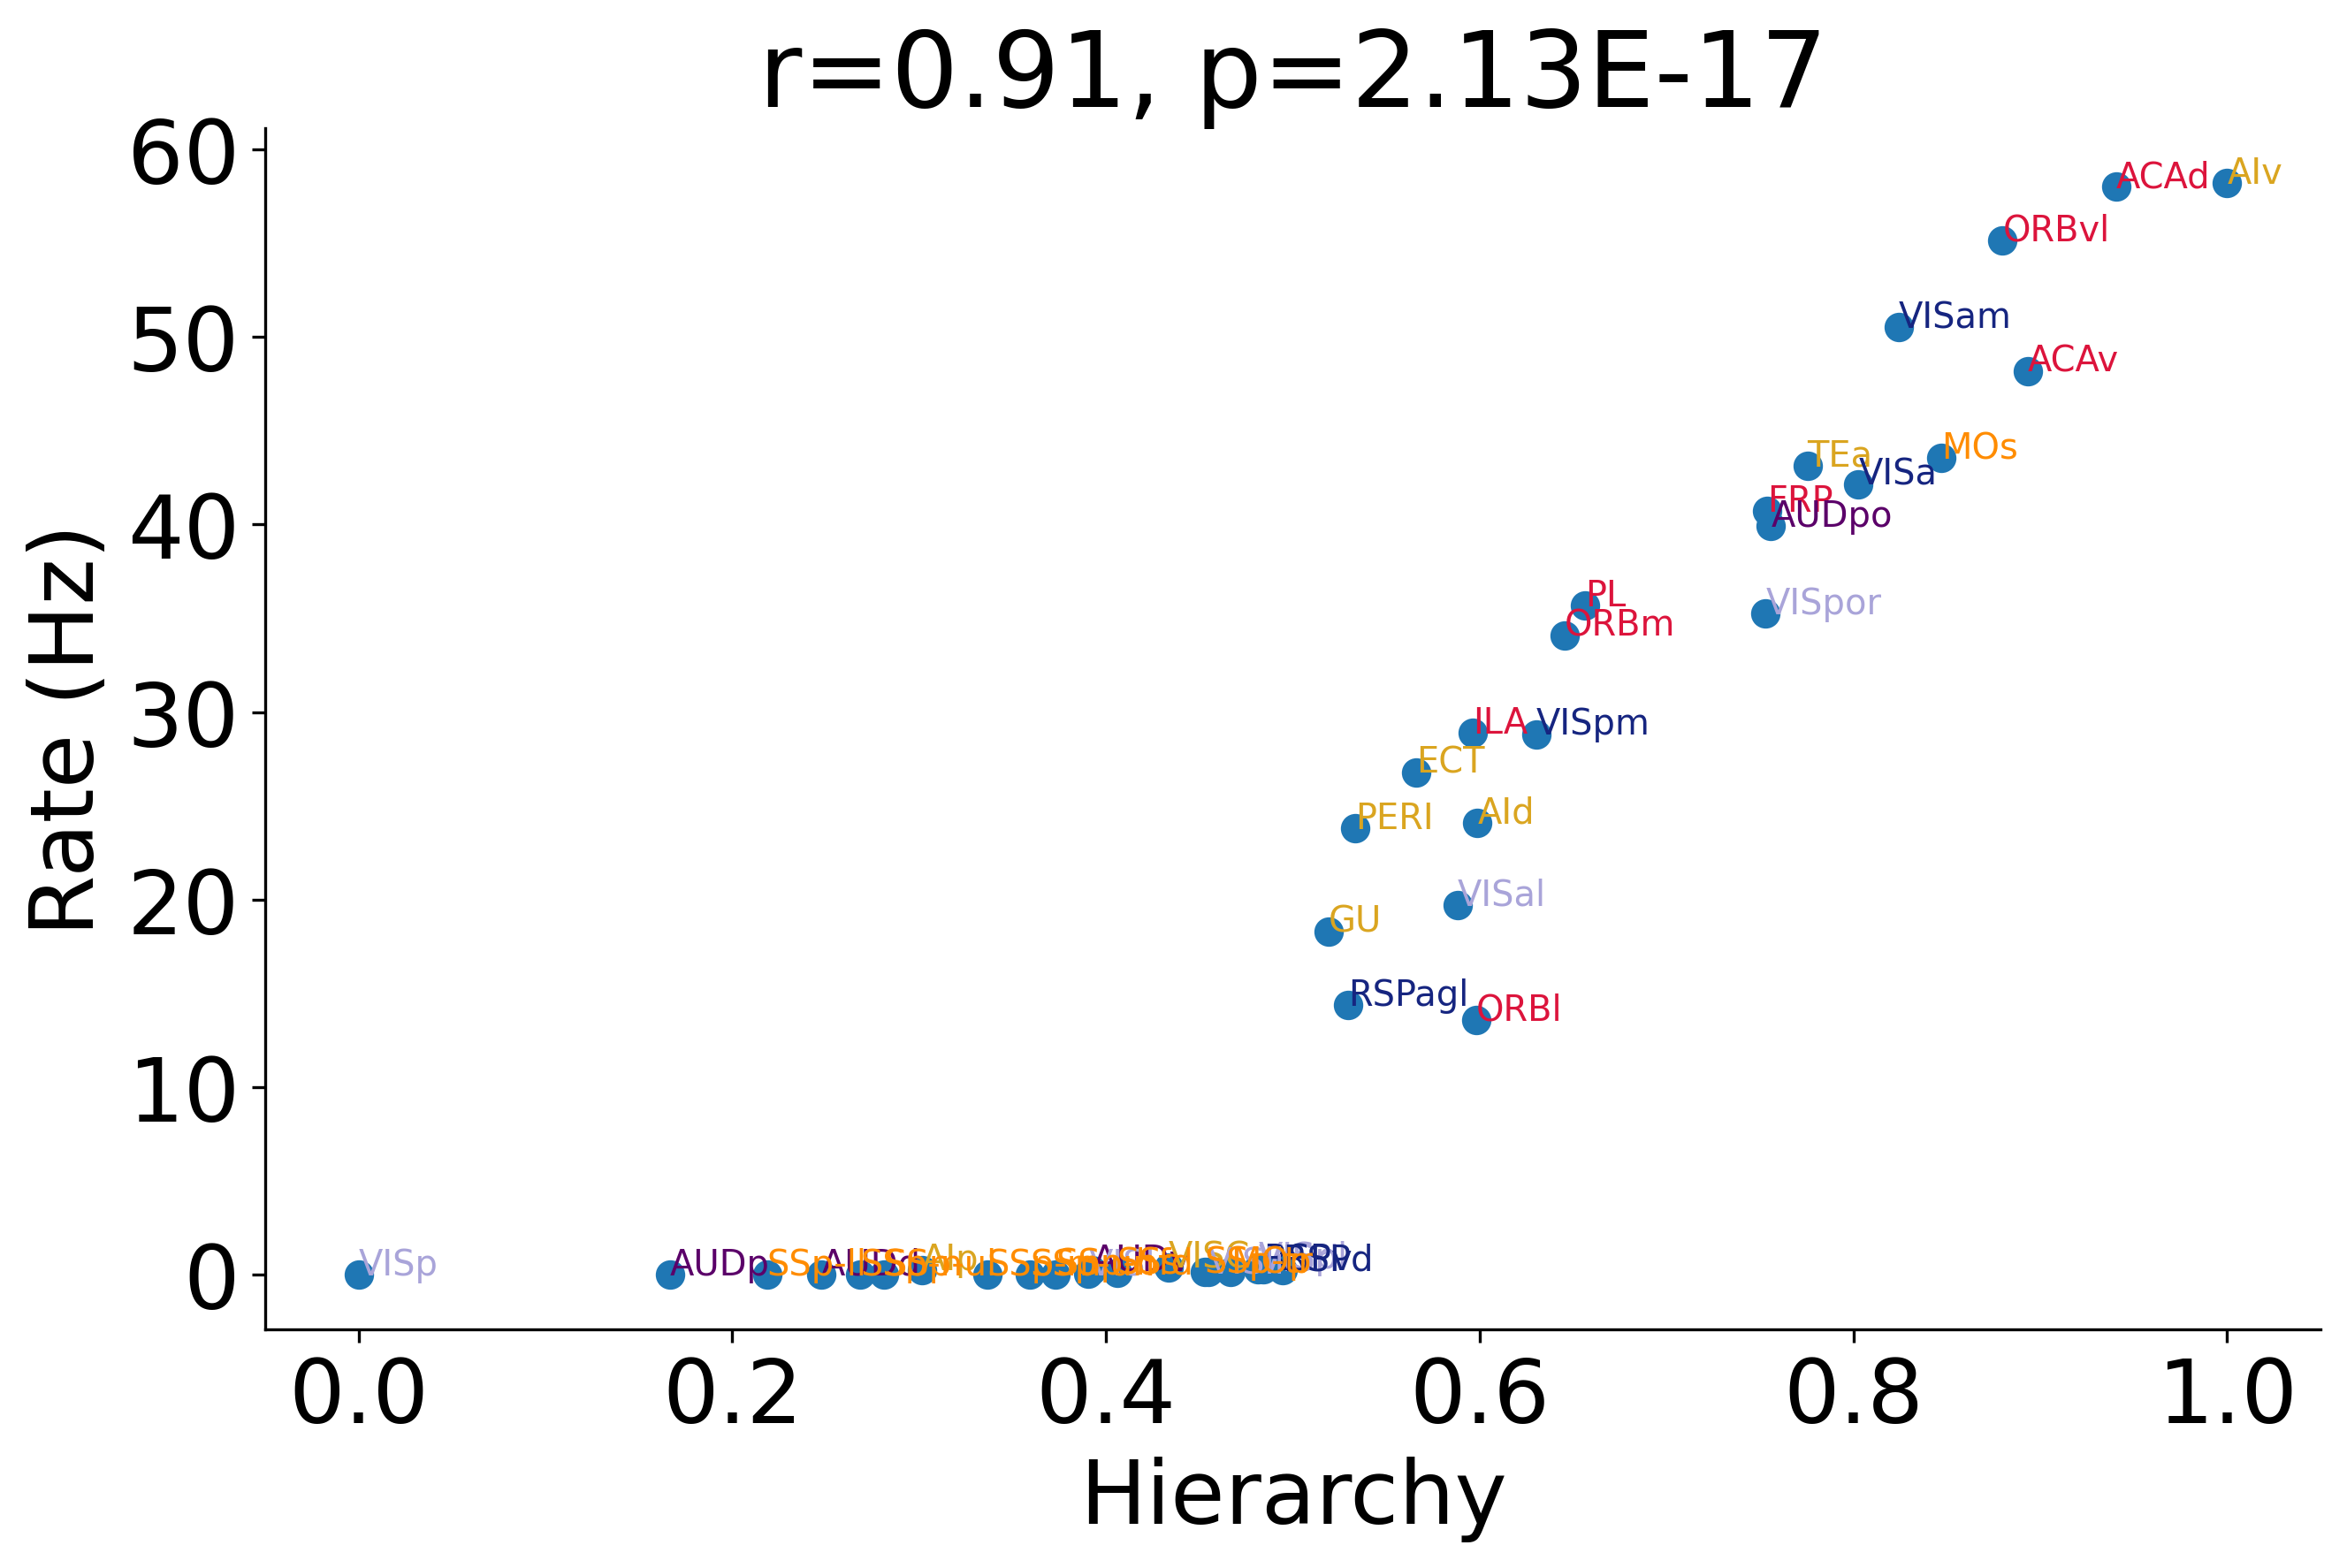

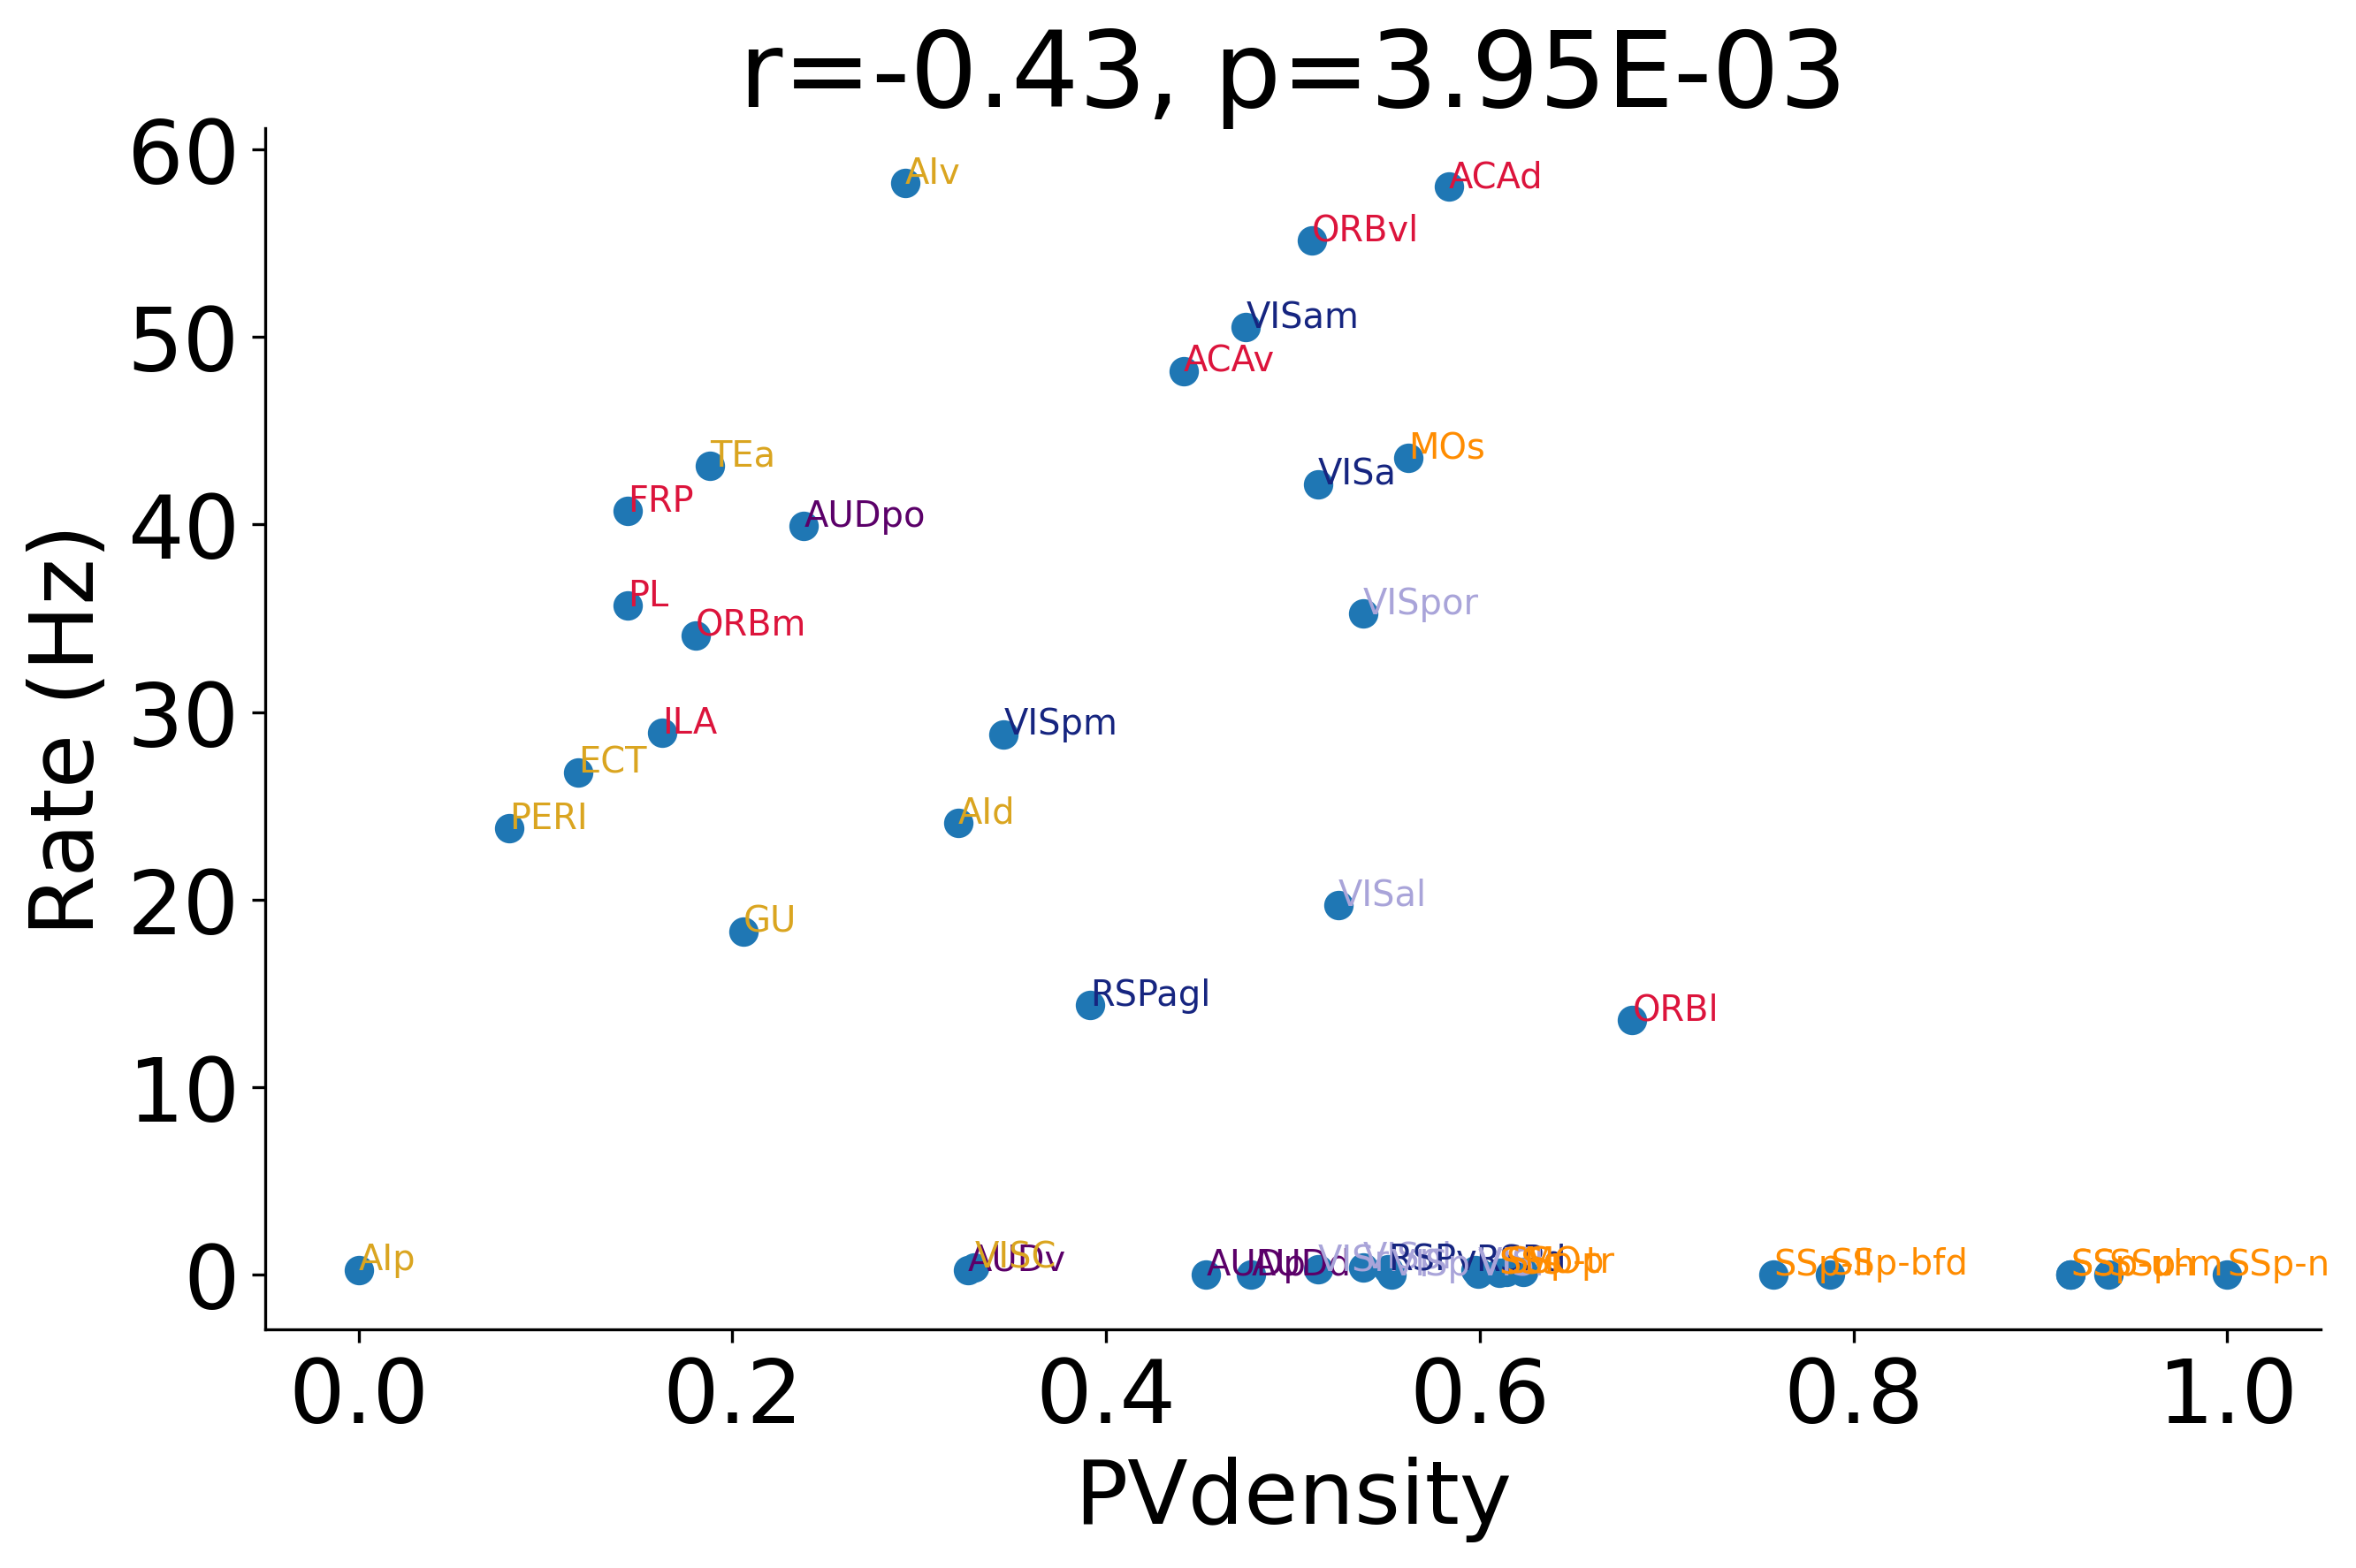

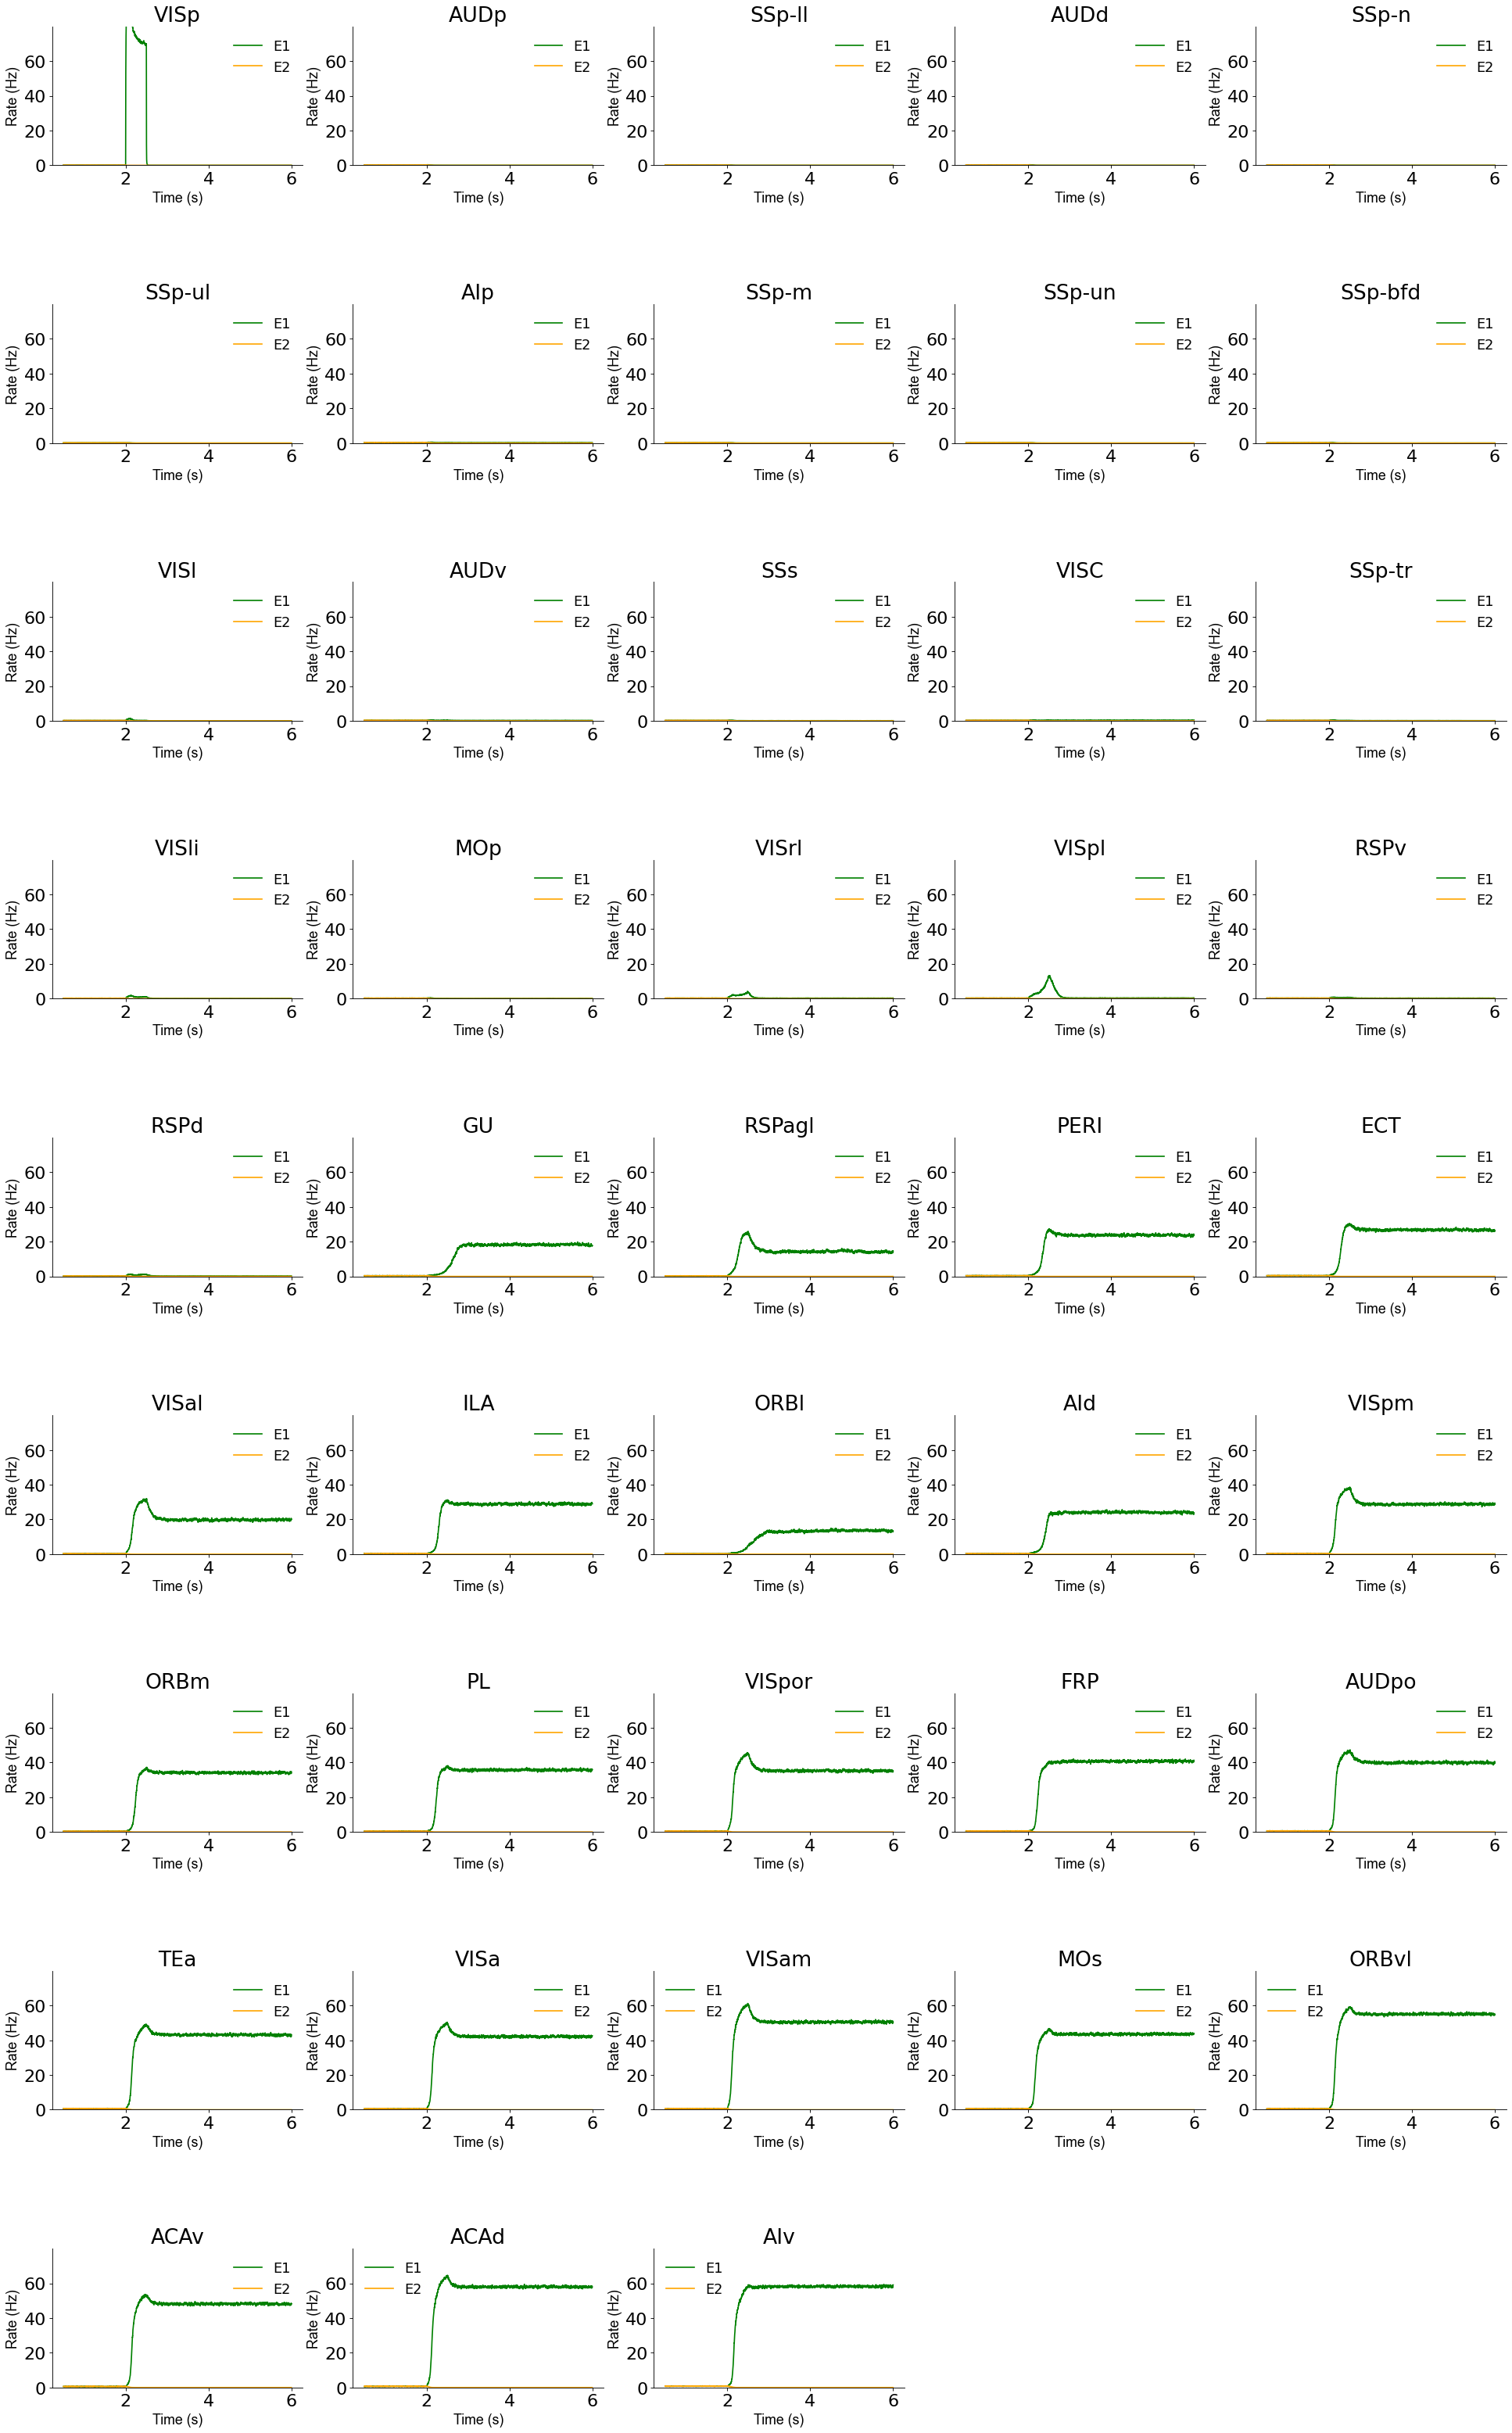

In [10]:
#mm22
PAthreshold = 5 #Hz
th_PAthreshold = 5 #Hz
persistentact_df =  model_V1.generatePAdf(PAthreshold)

if model_V1.thcxmodel == True:
    th_hierarchy = np.arange(0,1,1/40)
    th_persistentact_df = model_V1.generate_th_PAdf(th_PAthreshold, th_hierarchy)
model_V1.plotFRvsHier(False, True, 2, (10,6), 24, False, 'FRvsHier.pdf')
model_V1.plotFRvsPV(False, True, 2, (10,6), 24, False, 'FRvsPV.pdf')
model_V1.plotFRallarea(plot_interneuron = False, ylimit = 80, savefig = savefigflag, figfilename = 'FRallcortex.pdf')

if model_V1.thcxmodel == True:
    model_V1.plotFRthalarea(savefig = savefigflag, ylimit = 160, figfilename = 'FRallthalamus.pdf') 

In [24]:
# save date for stimulating V1, S1, and A1. and noLR V1 model
with open('results/model_V1.pkl', 'wb') as f:
    pickle.dump(model_V1, f)
